# Franken goam analysis

The data for this example can be found [here](https://cloudstor.aarnet.edu.au/plus/apps/files/?dir=/MRI-Linac%20Experimental%20Data/FrankenGoam%5EMr&fileid=6991872825).

I'm first going to set up the variables to read in this data

In [11]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from mri_distortion_toolkit.MarkerAnalysis import MarkerVolume, MatchedMarkerVolumes
from mri_distortion_toolkit.utilities import enumerate_subfolders
from mri_distortion_toolkit import calculate_harmonics
from mri_distortion_toolkit.utilities import plot_MarkerVolume_overlay
from mri_distortion_toolkit.utilities import get_dicom_data
from mri_distortion_toolkit.DistortionCorrection import ImageDomainDistortionCorrector
from mri_distortion_toolkit.utilities import plot_distortion_xyz_hist
from mri_distortion_toolkit.MarkerAnalysis import MatchedMarkerVolumes
from mri_distortion_toolkit.FieldCalculation import ConvertMatchedMarkersToBz
from mri_distortion_toolkit.Harmonics import SphericalHarmonicFit
from scipy.spatial import Delaunay



dataloc = Path(r'/home/brendan/Downloads/FrankenGoam^Mr/20221107 MR Linac^Test')
gt_data_loc = Path(r'/home/brendan/Downloads/FrankenGoam^Mr/CT/slicer_centroids.mrk.json')
scans = {'0': '01 localiser_gre',
         '1': '02 localiser_gre',
         '2': '03 localiser_gre',
         '3': '04 gre_trans_AP_330',
         '4': '05 gre_trans_PA_330',
         '5': '06 gre_sag_AP_330',
         '6': '07 gre_sag_PA_330',
         '7': '08 gre_cor_RL_330',
         '8': '09 gre_cor_LR_330',
         '9': '10 t1_tse_256_sag',
         '10': '11 t1_tse_256_sag_PA',
         '11': '12 t1_tse_256_tra_PA',
         '12': '13 t1_tse_256_sag_HF',
         '13': '14 t1_tse_256_sag_FH',  # for this one had to add gaussian_image_filter_sd=0.8
         '14': '15 t1_tse_256_cor_RL',
         '15': '16 t1_tse_256_cor_LR',
         '16': '17 localiser_gre',
         '17': '18 t1_tse_256_sag_HF_rot',
         '18': '19 t1_tse_256_sag_FH_rot',
         '19': '20 trufi_sag_128_torsocoil',
         '20': '21 trufi_sag_128_torsocoil',
         '21': '22 trufi_sag_128_torsocoil'}

## Marker extraction

Our first step is to extract the markers from each phantom.
> **Note that you can skip this step if you have already extracted and saved the marker positions as the next steps will read in these data files.**

In [2]:
# process TSE images
scans_to_segment = ['9', '11', '12', '13', '14']
gaussian_sd = [1,1,1,0.8,1,1]
for scan, sd in zip(scans_to_segment, gaussian_sd):
    volume = MarkerVolume(dataloc / scans[scan] / 'Original', n_markers_expected=618, iterative_segmentation=True,
                          gaussian_image_filter_sd=sd)
    print(f'for {scans[scan]}, {volume.MarkerCentroids.shape[0]} markers found')
    volume.export_to_slicer()
    volume.save_dicom_data()

Using thresold of  331.1
total segmentation time:  300.2 s
for 10 t1_tse_256_sag, 618 markers found
Using thresold of  315.5
total segmentation time:  148.9 s
for 12 t1_tse_256_tra_PA, 618 markers found
Using thresold of  254.4
total segmentation time:  117.2 s
for 13 t1_tse_256_sag_HF, 618 markers found
Using thresold of  254.4
total segmentation time:  111.7 s
for 14 t1_tse_256_sag_FH, 618 markers found
Using thresold of  241.9
total segmentation time:  126.1 s
for 15 t1_tse_256_cor_RL, 618 markers found


## Marker Matching

The next step is to match the markers from each of the distorted datasets to the ground truth data. Note that we have previously segmented the ground truth data, and simply import the pre-segmented data here.

In [3]:
#align ground truth
gt_vol = MarkerVolume(gt_data_loc)
gt_vol.rotate_markers(yaxis_angle=180)
gt_vol.translate_markers(y_shift=-54)

tra_forward_vol = MarkerVolume(dataloc / scans['9'] / 'Original' / 'slicer_centroids.mrk.json')
tra_back_vol = MarkerVolume(dataloc / scans['11'] / 'Original' / 'slicer_centroids.mrk.json')
tra_match = MatchedMarkerVolumes(gt_vol, tra_forward_vol, reverse_gradient_data=tra_back_vol, n_refernce_markers=9)
tra_match.MatchedCentroids.to_csv('_data/tra_markers.csv')

sag_forward_vol = MarkerVolume(dataloc / scans['12'] / 'Original' / 'slicer_centroids.mrk.json')
sag_back_vol = MarkerVolume(dataloc / scans['13'] / 'Original' / 'slicer_centroids.mrk.json')
sag_match = MatchedMarkerVolumes(gt_vol, sag_forward_vol, reverse_gradient_data=sag_back_vol, n_refernce_markers=9)
sag_match.MatchedCentroids.to_csv('_data/sag_markers.csv')

cor_forward_vol = MarkerVolume(dataloc / scans['14'] / 'Original' / 'slicer_centroids.mrk.json')
cor_back_vol = MarkerVolume(dataloc / scans['15'] / 'Original' / 'slicer_centroids.mrk.json')
cor_match = MatchedMarkerVolumes(gt_vol, cor_forward_vol, reverse_gradient_data=cor_back_vol, n_refernce_markers=9)
cor_match.MatchedCentroids.to_csv('_data/cor_markers.csv')

[MarkerAnalysis.py: line 128  WARNING] MR data file dicom_data.json not found at C:\Users\bwhe3635\Downloads\FrankenGoam^Mr\FrankenGoam^Mr\CT. Continuing


aligning ground truth centroids by 
x    0.933333
y   -0.882222
z   -3.753333
dtype: float64
rotating ground truth centroids by 
[[ 0.99956145 -0.02737767 -0.0112856 ]
 [ 0.02757548  0.9994619   0.01776225]
 [ 0.01079323 -0.01806567  0.99977854]]
aligning ground truth centroids by 
x    0.824444
y   -0.777778
z   -3.697778
dtype: float64
rotating ground truth centroids by 
[[ 0.99948359 -0.0314802  -0.00644519]
 [ 0.03159597  0.99932529  0.01872583]
 [ 0.00585135 -0.0189198   0.99980388]]
aligning ground truth centroids by 
x    0.845556
y   -0.836667
z   -3.712222
dtype: float64
rotating ground truth centroids by 
[[ 0.99961028 -0.02775001 -0.00303719]
 [ 0.02779602  0.99948023  0.01632953]
 [ 0.00258247 -0.01640759  0.99986205]]


## Field calculation

Next step is to calculate the encoding fields from the distorted marker positions. Note that we obtain three field estimates; one from each forward/reverse marker set. Each field calculation includes an estimate of the gradient fields and the B0 field.

In [4]:
data_csv_loc = Path('_data').resolve()
# load the matched volume calculated in the previous step.
matched_volume = pd.read_csv(data_csv_loc / 'tra_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['9'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'tra_Bfields.csv')

matched_volume = pd.read_csv(data_csv_loc / 'sag_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['12'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'sag_Bfields.csv')

matched_volume = pd.read_csv(data_csv_loc / 'cor_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['14'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'cor_Bfields.csv')

## Harmonic calculation and averaging

We are now able to calculate the harmonics from each field data set.
Note that for each forward/reverse data set, we obtain:

- a good estimate of B0 (from the marker offsets in the frequency encode direction)
- A good estimate of the gradient in the **phase** and **frequency** direction.

The fields in the **slice encode** direction are not reliable, as in this direction we are not able to seperate out B0 and gradient effects. Therefore, we will simply discard these fields. The below table sums up which fields are involved in each direction:

| Scan orientation | Slice direction | Phase direction | Frequency direction |
| ---------------- | --------------- | --------------- | ------------------- |
| Transverse       | z               | **y**           | **x**               |
| Coronal          | y               | **x**           | **z**               |
| Sagital          | x               | **z**           | **y**               |

For each gradient, we obtain two estimates that we trust. We will simply take the average of these two estimates, and use this as our 'best guess'.

### Calculate all harmonics and save as csv:

In [5]:
# Transverse data
# ===================================================================================================================
FieldData = pd.read_csv(data_csv_loc / 'tra_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['9'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=5,
                                                                                scale=normalisation_factor)
# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_tra.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_tra.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_tra.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_tra.csv')
# ======================================================================================================================

# Sagital data
# ===================================================================================================================
FieldData = pd.read_csv(data_csv_loc / 'sag_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['12'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=5,
                                                                                scale=normalisation_factor)

# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_sag.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_sag.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_sag.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_sag.csv')
# ======================================================================================================================

# C data
# ===================================================================================================================
FieldData = pd.read_csv(data_csv_loc / 'cor_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['14'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=5,
                                                                                scale=normalisation_factor)

# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_cor.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_cor.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_cor.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_cor.csv')



Initial pk-pk:        9.889e+02 μT
Reconstructed pk-pk:  9.884e+02 μT
Residual pk-pk:       3.581e+00 μT ( 0.4%)
Initial pk-pk:        9.885e+02 μT
Reconstructed pk-pk:  9.889e+02 μT
Residual pk-pk:       2.371e+00 μT ( 0.2%)


[Harmonics.py: line 205  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        3.319e+02 μT
Reconstructed pk-pk:  3.338e+02 μT
Residual pk-pk:       5.242e+00 μT ( 1.6%)
Initial pk-pk:        2.444e+01 μT
Reconstructed pk-pk:  2.275e+01 μT
Residual pk-pk:       1.924e+01 μT ( 78.7%)
Initial pk-pk:        2.799e+02 μT
Reconstructed pk-pk:  2.790e+02 μT
Residual pk-pk:       4.997e+00 μT ( 1.8%)
Initial pk-pk:        9.357e+02 μT
Reconstructed pk-pk:  9.364e+02 μT
Residual pk-pk:       3.189e+00 μT ( 0.3%)


[Harmonics.py: line 205  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        1.114e+03 μT
Reconstructed pk-pk:  1.113e+03 μT
Residual pk-pk:       1.339e+01 μT ( 1.2%)
Initial pk-pk:        2.484e+01 μT
Reconstructed pk-pk:  2.507e+01 μT
Residual pk-pk:       1.845e+01 μT ( 74.3%)
Initial pk-pk:        9.368e+02 μT
Reconstructed pk-pk:  9.364e+02 μT
Residual pk-pk:       2.981e+00 μT ( 0.3%)
Initial pk-pk:        2.786e+02 μT
Reconstructed pk-pk:  2.776e+02 μT
Residual pk-pk:       4.812e+00 μT ( 1.7%)
Initial pk-pk:        1.112e+03 μT
Reconstructed pk-pk:  1.112e+03 μT
Residual pk-pk:       1.314e+01 μT ( 1.2%)


[Harmonics.py: line 205  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        2.853e+01 μT
Reconstructed pk-pk:  2.934e+01 μT
Residual pk-pk:       1.875e+01 μT ( 65.7%)


### take the average of the different harmonics:

In [6]:
G_x1 = pd.read_csv(data_csv_loc / 'G_x_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_x2 = pd.read_csv(data_csv_loc / 'G_x_Harmonics_cor.csv', index_col=0).squeeze("columns")
G_x = (G_x1 + G_x2) / 2
G_x.to_csv('_data/Gx.csv')

# Gy_Harmonics
G_y1 = pd.read_csv(data_csv_loc / 'G_y_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_y2 = pd.read_csv(data_csv_loc / 'G_y_Harmonics_sag.csv', index_col=0).squeeze("columns")
G_y = (G_y1 + G_y2) / 2
G_y.to_csv('_data/Gy.csv')

# Gz_Harmonics
G_z1 = pd.read_csv(data_csv_loc / 'G_z_Harmonics_sag.csv', index_col=0).squeeze("columns")
G_z2 = pd.read_csv(data_csv_loc / 'G_z_Harmonics_cor.csv', index_col=0).squeeze("columns")
G_z = (G_z1 + G_z2) / 2
G_z.to_csv('_data/Gz.csv')


# B0
B01 = pd.read_csv(data_csv_loc / 'B0_Harmonics_sag.csv', index_col=0).squeeze("columns")
B02 = pd.read_csv(data_csv_loc / 'B0_Harmonics_cor.csv', index_col=0).squeeze("columns")
B03 = pd.read_csv(data_csv_loc / 'B0_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_x = (B01 + B02 + B03) / 3
B01.to_csv('_data/B0.csv')
# input_data = pd.DataFrame({'x': [0, 0, 0], 'y': [0, 0, 0], 'z': [0, 0, 0], 'Bz': [0, 1, 2]})


## Assess distortion correction with different combination of harmonics/ data

OK, I won't actually put all the code here, but let's check the ability of these 'averaged' harmonics to correct for the phantom in it's original orientation:

| Slice orientation | x_mean (max)  | y_mean (max)  | z_mean (max)  |
| ----------------- | ------------- | ------------- | ------------- |
| Transverse        | 0.5 (4.9)     | 0.3 (2.3)     | **0.7 (4.0)** |
| Coronal           | 0.4 (1.6)     | **0.8 (6.7)** | 0.4 (3.5)     |
| Sagital           | **0.9 (5.7)** | 0.2 (1.2)     | 0.3 (3.7)     |

I have bolded the slice direction in each case. We don't correct very well in this direction, because we don't take into account the effects of B0 on the slice gradient. Apart from this, we are doing a really good job with distortion correction here.

## Assess distortion correction on independant dataset

We took some images with the phantom rotated 90 degrees, which will serve as an independant dataset. Let's check how our averaged harmonics perform:

In [11]:



distorted_data_loc = dataloc / scans['17'] / 'Original'  # this is a 'rotated' acquisition
dicom_data = get_dicom_data(distorted_data_loc / 'dicom_data.json')
GDC = ImageDomainDistortionCorrector(ImageDirectory=distorted_data_loc.resolve(),
                                gradient_harmonics=[Path('_data/Gx.csv').resolve(),
                                                    Path('_data/Gy.csv').resolve(),
                                                    Path('_data/Gz.csv').resolve()],
                                B0_harmonics=Path('_data/B0.csv').resolve(),
                                dicom_data=dicom_data,
                                ImExtension='dcm',
                                correct_through_plane=True,
                                correct_B0=True,
                                B0_direction='back')

GDC.correct_all_images()
GDC.save_all_images()  # saves as png so you can quickly inspect results
GDC.save_all_images_as_dicom()  # saves as dicom which can be read into analysis packages.

 |----------------------------------------------------------------------------------------------------| 0.0% 
 |███-------------------------------------------------------------------------------------------------| 3.1% 
 |██████----------------------------------------------------------------------------------------------| 6.1% 
 |█████████-------------------------------------------------------------------------------------------| 9.2% 
 |████████████----------------------------------------------------------------------------------------| 12.3% 
 |███████████████-------------------------------------------------------------------------------------| 15.3% 
 |██████████████████----------------------------------------------------------------------------------| 18.4% 
 |█████████████████████-------------------------------------------------------------------------------| 21.5% 
 |████████████████████████----------------------------------------------------------------------------| 24.5% 
 |███

[DistortionCorrection.py: line 233] 220562 negative pixels detected; setting these to zero and continuing


images export to png successful in 42.88257629999998 s
saving all data as dcm...
images exported to dicom in  0.5s


## Assess distortion correction

[MarkerAnalysis.py: line 128  WARNING] MR data file dicom_data.json not found at C:\Users\bwhe3635\Downloads\FrankenGoam^Mr\FrankenGoam^Mr\CT. Continuing


Using thresold of  385.6


[MarkerAnalysis.py: line 153  WARNING] For data C:\Users\bwhe3635\Downloads\FrankenGoam^Mr\FrankenGoam^Mr\20221107 MR Linac^Test\18 t1_tse_256_sag_HF_rot\Original\corrected_dcm
You entered that you expected to find 609, but actually found 600.


total segmentation time:  136.1 s
aligning ground truth centroids by 
x   -2.505428
y    0.234128
z   -1.775811
dtype: float64
rotating ground truth centroids by 
[[ 0.99983607 -0.01071352 -0.01459611]
 [ 0.01085806  0.99989244  0.0098593 ]
 [ 0.01448891 -0.01001617  0.99984486]]
mean distortion:  1.8 mm, std:  0.9 mm, Max:  6.6 mm
x_mean:  0.9 mm +-  0.8 mm. max  4.1 mm
y_mean:  1.1 mm +-  0.8 mm. max  5.0 mm
z_mean:  0.8 mm +-  0.6 mm. max  3.5 mm


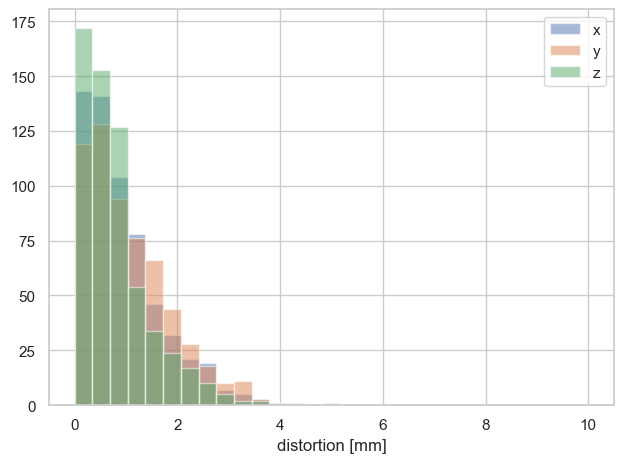

In [16]:
# have to realign the ground truth to the new position
from copy import deepcopy
gt_vol2 = MarkerVolume(gt_data_loc)
gt_vol2.rotate_markers(yaxis_angle=90)
gt_vol2.rotate_markers(zaxis_angle=180)
gt_vol2.MarkerCentroids = gt_vol2.MarkerCentroids[gt_vol2.MarkerCentroids.x > -150]
gt_vol2.translate_markers(x_shift=-14, y_shift=55, z_shift=-3)
gt_vol2.rotate_markers(xaxis_angle=180)
nmarkers = 609

corrected_volume = MarkerVolume(distorted_data_loc / 'corrected_dcm',
                                n_markers_expected=nmarkers,
                                iterative_segmentation=True,
                                threshold=None,
                                gaussian_image_filter_sd=0.8)
matched_volume_corrected = MatchedMarkerVolumes(gt_vol2, corrected_volume, n_refernce_markers=9)
matched_volume_corrected.report()
plot_distortion_xyz_hist(matched_volume_corrected)

This is a somewhat dissapointing result; substantially worse than the non-rotated data.

I have given this a lot (too much) thought, and have got the following hypotheses:

### H1: rotated data contains data outside the sphere of the initial data

Because we actually have an elipsoid of markers rather than a sphere of markers, the rotated dataset will contain markers substantially outside the sphere of the fitting dataa. These markers would be expected to be less accurate than the ones inside the sphere.

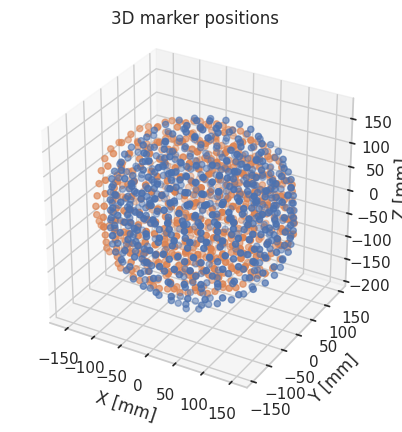

In [4]:
data_markers = MarkerVolume(dataloc / scans['9'] / 'Original' / 'slicer_centroids.mrk.json')
test_markers = MarkerVolume(dataloc / scans['17'] / 'Original' / 'slicer_centroids.mrk.json')
plot_MarkerVolume_overlay([data_markers, test_markers])

Indeed, we can see that there are quite a number of markers outside the measurement data. We can use a convex hull to remove these markers. This is actually a bit complicated: we need to figure out which of our test markers lay inside the volume of the 'data' markers. then we need to figure out the equivalent corrected test markers, and remove these from the volume:

aligning ground truth centroids by 
x   -2.251111
y   -0.693333
z    0.940000
dtype: float64
rotating ground truth centroids by 
[[ 0.9999482  -0.00656647 -0.00777665]
 [ 0.00664679  0.99992438  0.01034703]
 [ 0.00770812 -0.01039818  0.99991623]]


/tmp/ipykernel_9348/2175905718.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data_frame.rename(columns={'x_gnl': 'x', 'y_gnl': 'y', 'z_gnl': 'z'}, inplace=True)


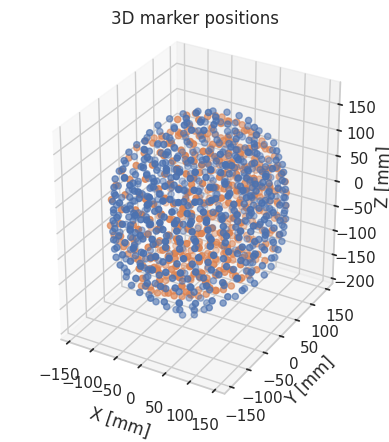

[MarkerAnalysis.py: line 128  WARNING] MR data file dicom_data.json not found at /home/brendan/Downloads/FrankenGoam^Mr/CT. Continuing


aligning ground truth centroids by 
x   -2.480000
y    0.167778
z   -1.752222
dtype: float64
rotating ground truth centroids by 
[[ 0.99980198 -0.01215338 -0.01575773]
 [ 0.01231608  0.99987142  0.01026897]
 [ 0.0156309  -0.01046101  0.99982311]]
mean distortion:  1.6 mm, std:  0.8 mm, Max:  4.0 mm
x_mean:  0.8 mm +-  0.6 mm. max  3.1 mm
y_mean:  1.0 mm +-  0.7 mm. max  3.4 mm
z_mean:  0.7 mm +-  0.5 mm. max  2.4 mm


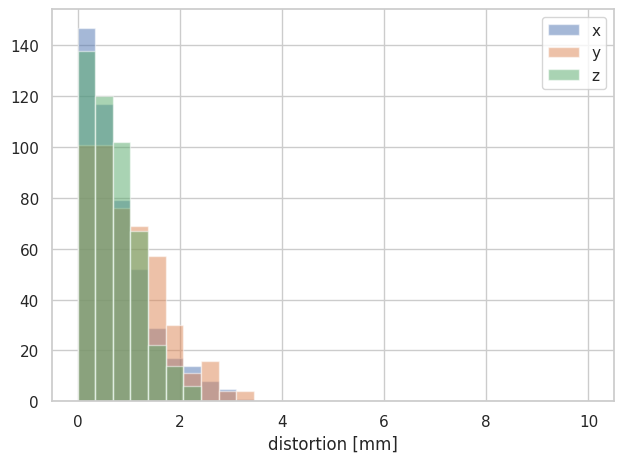

In [15]:
test_markers_corrected = MarkerVolume(dataloc / scans['17'] / 'Original' / 'corrected_dcm' / 'slicer_centroids.mrk.json')
matched_volume = MatchedMarkerVolumes(test_markers, test_markers_corrected, n_refernce_markers=9)


XA = data_markers.MarkerCentroids[['x', 'y', 'z']].to_numpy()
hull = Delaunay(XA)
keep_marker_ind = []
for marker in matched_volume.MatchedCentroids.iterrows():
    XB = marker[1][4:7].to_numpy()
    is_in_data_hull = hull.find_simplex(XB) >= 0
    keep_marker_ind.append(is_in_data_hull)

# now make a new marker Volume
matched_volume.MatchedCentroids = matched_volume.MatchedCentroids[keep_marker_ind]
_data_frame = matched_volume.MatchedCentroids[['x_gnl', 'y_gnl', 'z_gnl']]
_data_frame.rename(columns={'x_gnl': 'x', 'y_gnl': 'y', 'z_gnl': 'z'}, inplace=True)
new_corrected_volume = MarkerVolume(_data_frame)

# demonstrate overlay
plot_MarkerVolume_overlay([data_markers, new_corrected_volume])

# get ground truth data
gt_vol = MarkerVolume(gt_data_loc)
gt_vol.rotate_markers(yaxis_angle=90)
gt_vol.rotate_markers(zaxis_angle=180)
gt_vol.MarkerCentroids = gt_vol.MarkerCentroids[gt_vol.MarkerCentroids.x > -150]
gt_vol.translate_markers(x_shift=-14, y_shift=55, z_shift=-3)
gt_vol.rotate_markers(xaxis_angle=180)
# match filtered corrected data to ground truth
matched_volume = MatchedMarkerVolumes(gt_vol, new_corrected_volume, n_refernce_markers=9)
matched_volume.report()
# plot results
plot_distortion_xyz_hist(matched_volume)

You can see that compared with the original case, we are now only assessing the markers inside the fitting data. 

Below is a comparison of the original versus trimmed correction. The trimming has certainly improved things, particularly in terms of the maximum distortion - however, the correction is still not really that good... 

**Original results**
```
mean distortion:  1.8 mm, std:  0.9 mm, Max:  6.6 mm
x_mean:  0.9 mm +-  0.8 mm. max  4.1 mm
y_mean:  1.1 mm +-  0.8 mm. max  5.0 mm
z_mean:  0.8 mm +-  0.6 mm. max  3.5 mm
```

**Results after trimming**
```
mean distortion:  1.6 mm, std:  0.8 mm, Max:  4.0 mm
x_mean:  0.8 mm +-  0.6 mm. max  3.1 mm
y_mean:  1.0 mm +-  0.7 mm. max  3.4 mm
z_mean:  0.7 mm +-  0.5 mm. max  2.4 mm
```

### H2: poor fitting of harmonics, particularly in the Z direction

We have 35 mm spacing between the slices (it should have been 30 but whatever).
As a result, over our 150 mm DSV, we get about 8 slices of markers. In principle, this should be sufficient for a 7th order fit, and we are only attempting a 5th order fit. However, taking into account that we have some segmentation error etc., it is possible that we are not getting especially robust fitting, particularly in the Z direction.

To test this hypothesis, I will make a new class that allows us to compare harmonics, and compare the averaged (original phantom orientation) with the rotated harmonics.

In [20]:
class CompareHarmonics:
    """
    This is a class mostly intended for debugging/developing.
    It provides tools to compare the differences between two harmonic series.
    """

    def __init__(self, series1, series2):

        self._series1 = pd.read_csv(series1, index_col=0).squeeze("columns")
        self._series2 = pd.read_csv(series2, index_col=0).squeeze("columns")
        n_order1 = int(np.sqrt(self._series1.shape[0] - 1))
        n_order2 = int(np.sqrt(self._series2.shape[0] - 1))
        self.series1_fit = SphericalHarmonicFit(self._series1, n_order=n_order1)
        self.series2_fit = SphericalHarmonicFit(self._series2, n_order=n_order2)
        self._construct_data_frame()

    def _construct_data_frame(self):

        self.harmonics_comparison = pd.concat([self.series1_fit.HarmonicsPk_Pk,
                                               self.series2_fit.HarmonicsPk_Pk], axis=1)
        abs_error = np.abs(np.subtract(self.series1_fit.HarmonicsPk_Pk,
                                       self.series2_fit.HarmonicsPk_Pk))
        self.harmonics_comparison['absolute_error'] = abs_error
        percent_error = np.abs(np.divide(self.series1_fit.HarmonicsPk_Pk * 100,
                                         self.series2_fit.HarmonicsPk_Pk) - 100)
        self.harmonics_comparison['percent_error'] = percent_error

    def plot_cut_planes(self):
        self.series1_fit.plot_cut_planes()
        self.series2_fit.plot_cut_planes()

    def plot_harmonics(self, cut_off=.005, label_data=True, y_range=None):

        plt.figure(figsize=[10, 5])
        # ax = sns.barplot(self.HarmonicsPk_Pk, y='pk-pk [\u03BCT]', x=)
        CutOffInd1 = abs(self.series1_fit.HarmonicsPk_Pk) < cut_off * abs(self.series1_fit.HarmonicsPk_Pk).max()
        CutOffInd2 = abs(self.series2_fit.HarmonicsPk_Pk) < cut_off * abs(self.series2_fit.HarmonicsPk_Pk).max()
        CutOffInd = np.logical_not(np.logical_or(np.logical_not(CutOffInd1), np.logical_not(CutOffInd2)))
        HarmonicsToPlot_1 = self.series1_fit.HarmonicsPk_Pk.drop(self.series1_fit.HarmonicsPk_Pk[CutOffInd].index)
        HarmonicsToPlot_2 = self.series2_fit.HarmonicsPk_Pk.drop(self.series2_fit.HarmonicsPk_Pk[CutOffInd].index)

        HarmonicsToPlot_1 = HarmonicsToPlot_1.to_frame()
        HarmonicsToPlot_2 = HarmonicsToPlot_2.to_frame()
        HarmonicsToPlot_1['series'] = 'one'
        HarmonicsToPlot_2['series'] = 'two'
        HarmonicsToPlot = pd.concat([HarmonicsToPlot_1, HarmonicsToPlot_2])
        HarmonicsToPlot = HarmonicsToPlot.reset_index()
        HarmonicsToPlot = HarmonicsToPlot.rename(columns={0: "pk_pk"})

        axs = sns.barplot(data=HarmonicsToPlot, x="index", y="pk_pk", hue="series")
        if y_range:
            axs.set_ylim(y_range)
        axs.set_title(f'Principle Harmonics pk-pk (>{cut_off * 100: 1.1f}% of max)')

        axs.set_ylabel('pk-pk [\u03BCT]')
        for item in axs.get_xticklabels():
            item.set_rotation(45)
        if label_data:
            for i in axs.containers:
                axs.bar_label(i, )
        plt.show()

Using this class, we can try and get a sense of how the different harmonics differ:

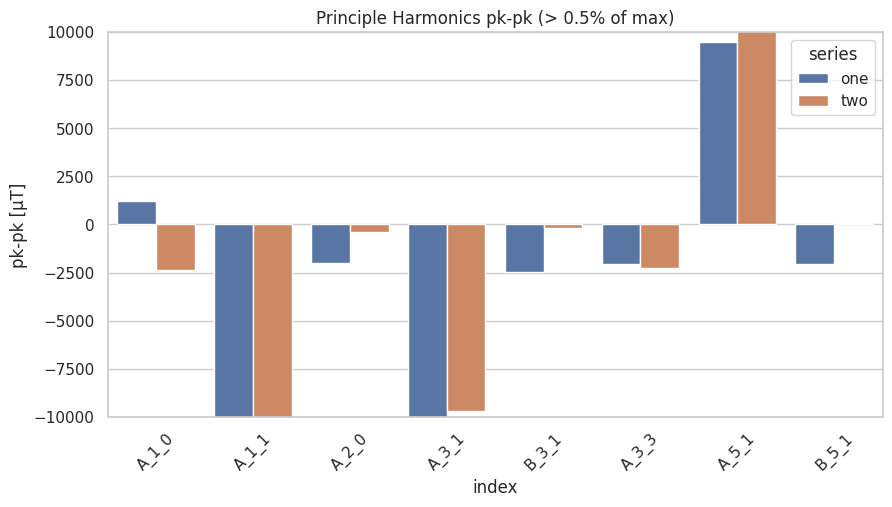

In [21]:
data_loc1 = Path('_data/G_x_Harmonics_rot.csv')
data_loc2 = Path('_data/Gx.csv')
Gy_compare = CompareHarmonics(data_loc1, data_loc2)
Gy_compare.plot_harmonics(cut_off=.005, label_data=False, y_range=[-10000, 10000])

OK, this is pretty interesting! the biggest differences between these two series are A_1_0, and A_2_0. **these are both harmonics which vary only in the z direction**. So, this is quite support of the hypothesis that we don't have a great fit in the z direction.
We also see some big differences in B_3_1 and B_5_1 - I don't have a good theory for why this is the case. These harmonics vary in all directions so it could still be the z resolution.
Another important thing to note is that Gx is the slice direction for the rotated data. As such, this contains both gradient and B0 effects, so this is another reason to expect to see differences in the harmonics.

Let's check the other harmonics:

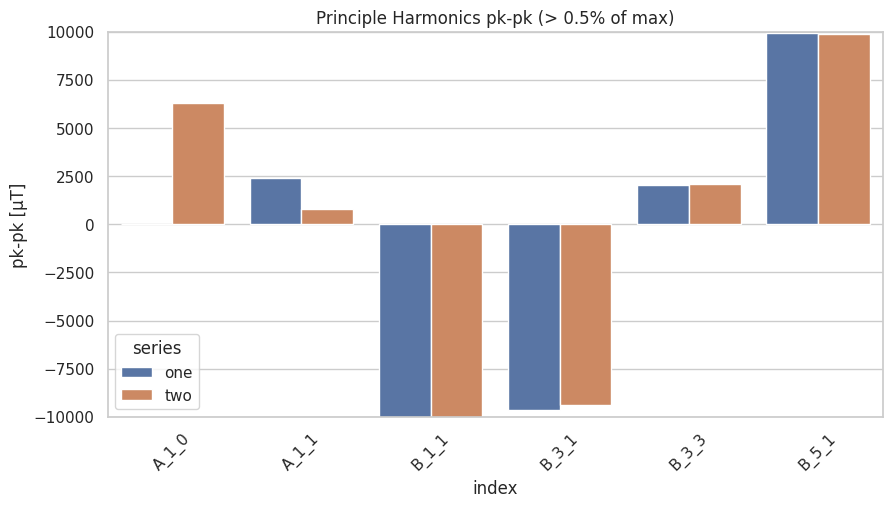

In [23]:
data_loc1 = Path('_data/G_y_Harmonics_rot.csv')
data_loc2 = Path('_data/Gy.csv')
Gy_compare = CompareHarmonics(data_loc1, data_loc2)
Gy_compare.plot_harmonics(cut_off=.005, label_data=False, y_range=[-10000, 10000])

OK!! Again, the biggest difference here is in A_1_0 - a harmonics which varies only in z. 
the hypothesis about the poor z fit is looking good....

y is the frequency direction, so while we would hope that we have removed the B0 effects from these harmonics, it can't be guaranteed...

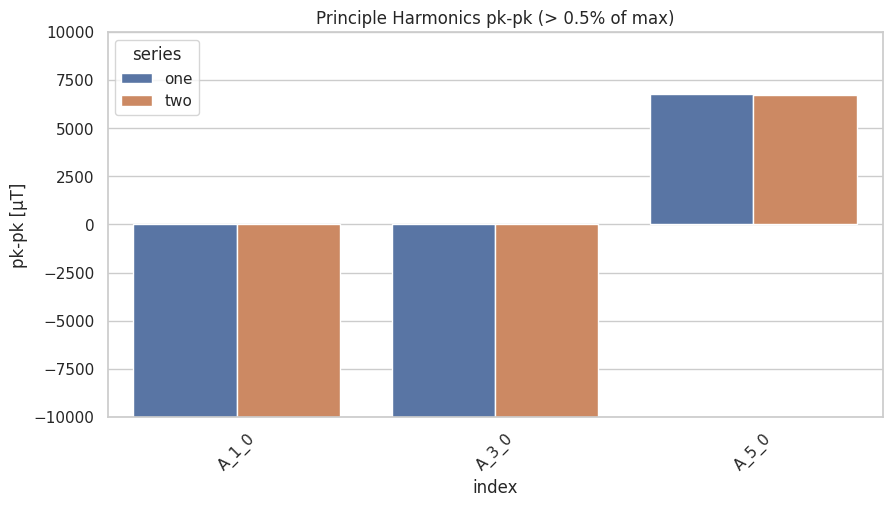

In [27]:
data_loc1 = Path('_data/G_z_Harmonics_rot.csv')
data_loc2 = Path('_data/Gz.csv')
Gy_compare = CompareHarmonics(data_loc1, data_loc2)
Gy_compare.plot_harmonics(cut_off=.005, label_data=False, y_range=[-10000, 10000])

Interestingly, our Gz gradient exhibits the least difference of these harmonics. I'm not quite sure what to make of this; maybe I would have expected it to be worse, however it does not appear to be the case. Z is the phase direction, so these har

I'm going to try the correction procedure again, after making the following changes to the averaged harmonics:

```
Gx[A_1_0] = G_x_Harmonics_rot[A_1_0]
Gx[A_2_0] = G_x_Harmonics_rot[A_2_0]
Gy[A_1-0] = G_y_Harmonics_rot[A_1_0]
```

following this, I get the following result:

**replace zonal harmonics in Gx and Gy**
```
mean distortion:  1.4 mm, std:  0.9 mm, Max:  6.0 mm
x_mean:  0.8 mm +-  0.7 mm. max  3.9 mm
y_mean:  0.9 mm +-  0.8 mm. max  4.5 mm
z_mean:  0.4 mm +-  0.4 mm. max  2.0 mm
```

This has certainly improved things - interestingly enough, mostly in the z direction!
We would expect x direction to be the worst since we don't apply B0 correction in the slice direction, however y is actually slightly worse..

When I also applied the convex hull filtering of markers, I got this:

```
mean distortion:  1.2 mm, std:  0.7 mm, Max:  4.1 mm
x_mean:  0.7 mm +-  0.6 mm. max  3.5 mm
y_mean:  0.8 mm +-  0.6 mm. max  3.0 mm
z_mean:  0.3 mm +-  0.3 mm. max  1.4 mm
```

compare this to our table of results from the non rotated data:

| Slice orientation | x_mean (max)  | y_mean (max)  | z_mean (max)  |
| ----------------- | ------------- | ------------- | ------------- |
| Transverse        | 0.5 (4.9)     | 0.3 (2.3)     | **0.7 (4.0)** |
| Coronal           | 0.4 (1.6)     | **0.8 (6.7)** | 0.4 (3.5)     |
| Sagital           | **0.9 (5.7)** | 0.2 (1.2)     | 0.3 (3.7)     |

and it's clear taht while we are certainly worse in this direction, we aren't THAT much worse...

## Conclusions and thoughts for future work

based on these results, I believe that we probably do not get great fitting of the harmonics in the z direction.
we get a fit good enough to correct the results we have (e.g. the data that generated the fit) but not necesarily good enough to generalise in other directions.

to test this hypothesis, we could collect more data where we take one set of measurements with the phantom slices in z (as we have done) then repeat this with the slices in x and y. We could use e.g.  a 45 degree rotation as our independant test set.

On the other hand, we have to consider whether we want to consider chasing refinements in distortion correction, which is not necesarily the primary focus of the paper I am working on, or save this for a different paper "implementation of distortion correction on a...etc"

